In [504]:
import polars as pl 
import re
wb_latam = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/wb_latam.csv")
destatis_0001  = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv")
destatis_0003  = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0003_clean.csv")
destatis_0004  = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0004_clean.csv")
daad_clean     = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/daad_clean.csv")

In [505]:
latam = pl.read_csv('/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/SDG_UNESCO/latam_countries.csv')
latam = latam.select(
    pl.col('country_en').str.strip_chars().alias('country_en'),
    pl.col('iso3').str.strip_chars().alias('iso3')
)

In [506]:
ALIASES = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Dominican Republic": "Dominican Republic",
    "Bahamas": "Bahamas",  
    "Côte d'Ivoire": "Cote d'Ivoire", 
}




In [507]:
def apply_alias_expr(col: str):
    expr = pl.col(col)
    for src, tgt in ALIASES.items():
        expr = expr.map_elements(lambda x, src=src, tgt=tgt: tgt if x == src else x)
    return expr


In [508]:
def to_year(expr):
    return pl.col(expr).cast(pl.Utf8).str.extract(r"(\d{4})").cast(pl.Int32)


In [509]:
def to_int(expr):
    return (
        pl.when(pl.col(expr).is_null()).then(None)
        .when(pl.col(expr).dtype == pl.Utf8)
            .then(pl.col(expr).str.replace_all(',','').cast(pl.Int64, strict=False))
        .otherwise(pl.col(expr).cast(pl.Int64, strict=False))
        .alias(expr)
        
    )

In [510]:
def extract_year(colname: str):
    return (
        pl.col(colname)
        .cast(pl.Utf8)
        .str.extract(r"(\d{4})")
        .cast(pl.Int32)
    )

In [511]:
def to_int(colname: str):
    return (
        pl.when(pl.col(colname).is_null()).then(None)
        .otherwise(pl.col(colname).cast(pl.Utf8).str.replace_all(",", "").cast(pl.Int64, strict=False))
        .alias(colname)
    )

## female scholarships DAAD tables

In [512]:
# keep only LATAM countries
daad_latam = (
    daad_clean
    .with_columns(apply_alias_expr('Country').alias('Country'))
    .join(latam, left_on='Country', right_on='country_en', how='inner')
)

In [513]:
#female scholarship measure
female_cols = [c for c in daad_latam.columns if c.endswith('_female')]
prefer = ['total_female', 'individual_female', 'project_female']
pick = [c for c in prefer if c in female_cols]

daad_female = (
    daad_latam
    .with_columns([
        (pl.col('total_female') if 'total_female' in daad_latam.columns
         else pl.sum_horizontal([pl.col(c) for c in pick])).alias('daad_female_scholarships')
    ])
    .select(['Country', 'iso3', 'year', 'daad_female_scholarships'])
    .rename({'Country':'country'})
)

print(daad_female.head(10))

shape: (10, 4)
┌────────────────────┬──────┬──────┬──────────────────────────┐
│ country            ┆ iso3 ┆ year ┆ daad_female_scholarships │
│ ---                ┆ ---  ┆ ---  ┆ ---                      │
│ str                ┆ str  ┆ i64  ┆ i64                      │
╞════════════════════╪══════╪══════╪══════════════════════════╡
│ Argentina          ┆ ARG  ┆ 2020 ┆ 428                      │
│ Bahamas            ┆ BHS  ┆ 2020 ┆ 5                        │
│ Barbados           ┆ BRB  ┆ 2020 ┆ 27                       │
│ Belize             ┆ BLZ  ┆ 2020 ┆ 301                      │
│ Brazil             ┆ BRA  ┆ 2020 ┆ 452                      │
│ Chile              ┆ CHL  ┆ 2020 ┆ 198                      │
│ Costa Rica         ┆ CRI  ┆ 2020 ┆ 76                       │
│ Dominica           ┆ DMA  ┆ 2020 ┆ 62                       │
│ Dominican Republic ┆ DOM  ┆ 2020 ┆ 59                       │
│ Ecuador            ┆ ECU  ┆ 2020 ┆ 157                      │
└────────────────────┴───

## Female students in Germany - DESTATIS

In [514]:
destatis_0001 = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv")
print(destatis_0001.columns)
print(destatis_0001.head(5))


['year', 'germans_male', 'germans_female', 'germans_total', 'foreigners_male', 'foreigners_female', 'foreigners_total', 'total_male', 'total_female', 'total_total']
shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ year      ┆ germans_m ┆ germans_f ┆ germans_t ┆ … ┆ foreigner ┆ total_mal ┆ total_fem ┆ total_to │
│ ---       ┆ ale       ┆ emale     ┆ otal      ┆   ┆ s_total   ┆ e         ┆ ale       ┆ tal      │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ i64       ┆ i64       ┆ i64       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ WT        ┆ 907403    ┆ 727254    ┆ 1634657   ┆ … ┆ 165994    ┆ 999724    ┆ 800927    ┆ 1800651  │
│ 1998/99   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ WT        

In [515]:
## FOREIGN FEMALE STUDENTS - DF 0001
destastis_year_foreign_fem = (
    destatis_0001
    .with_columns([
        extract_year('year').alias('year'),
        to_int('foreigners_female')
    ])
    .select(['year', 'foreigners_female'])
    .rename({'foreigners_female': 'destatis_foreign_female_total'})
)

print(destastis_year_foreign_fem)

shape: (27, 2)
┌──────┬───────────────────────────────┐
│ year ┆ destatis_foreign_female_total │
│ ---  ┆ ---                           │
│ i32  ┆ i64                           │
╞══════╪═══════════════════════════════╡
│ 1998 ┆ 73673                         │
│ 1999 ┆ 79605                         │
│ 2000 ┆ 87121                         │
│ 2001 ┆ 98410                         │
│ 2002 ┆ 109821                        │
│ …    ┆ …                             │
│ 2020 ┆ 193470                        │
│ 2021 ┆ 205538                        │
│ 2022 ┆ 213717                        │
│ 2023 ┆ 218651                        │
│ 2024 ┆ 227670                        │
└──────┴───────────────────────────────┘


In [516]:
## BY FIELD OF STUDY DF 0003
destatis_fields = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),   
        pl.col("field").alias("field"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")   
    )
    .select(["year", "field", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_field"})
)

print(destatis_fields.head(20))
print(destatis_fields.select("year").unique().sort("year"))


shape: (20, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2024 ┆ Administration of Justice       ┆ 2                       │
│ 2024 ┆ Administrative Science/Public … ┆ 348                     │
│ 2024 ┆ Adult Education and Extracurri… ┆ 100                     │
│ 2024 ┆ Aeronautical and Aerospace Eng… ┆ 419                     │
│ 2024 ┆ African Studies                 ┆ 169                     │
│ …    ┆ …                               ┆ …                       │
│ 2024 ┆ Applied Systems Science         ┆ 442                     │
│ 2024 ┆ Arabic/Arabic Studies           ┆ 81                      │
│ 2024 ┆ Archaeology                     ┆ 347                     │
│ 2024 ┆ Archaeomet

In [517]:
## by degree type - df 0004
destatis_degrees = (
    destatis_0004
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("degree").alias("degree"),
        to_int("foreigners_female")
    ])
    .select(["year", "degree", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_degree"})
)

print(destatis_degrees.filter(pl.col("year") == 2020).sort("foreign_female_by_degree", descending=True).head(10))


shape: (0, 3)
┌──────┬────────┬──────────────────────────┐
│ year ┆ degree ┆ foreign_female_by_degree │
│ ---  ┆ ---    ┆ ---                      │
│ i32  ┆ str    ┆ i64                      │
╞══════╪════════╪══════════════════════════╡
└──────┴────────┴──────────────────────────┘


In [518]:
print("Shape:", destatis_0004.shape)
print("Columns:", destatis_0004.columns)
print(destatis_0004.head(20))


Shape: (293, 11)
Columns: ['year', 'degree', 'germans_male', 'germans_female', 'germans_total', 'foreigners_male', 'foreigners_female', 'foreigners_total', 'total_male', 'total_female', 'general_total']
shape: (20, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ year      ┆ degree    ┆ germans_m ┆ germans_f ┆ … ┆ foreigner ┆ total_mal ┆ total_fem ┆ general_ │
│ ---       ┆ ---       ┆ ale       ┆ emale     ┆   ┆ s_total   ┆ e         ┆ ale       ┆ total    │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ WT        ┆ Administr ┆ 681       ┆ 2440      ┆ … ┆ 2         ┆ 681       ┆ 2442      ┆ 3123     │
│ 2024/25   ┆ ation of  ┆           ┆           ┆   ┆           ┆         

In [519]:
print(destatis_0004.select("foreigners_female").head(10))


shape: (10, 1)
┌───────────────────┐
│ foreigners_female │
│ ---               │
│ str               │
╞═══════════════════╡
│ 2                 │
│ 348               │
│ 100               │
│ 419               │
│ 169               │
│ 308               │
│ 361               │
│ 1253              │
│ 830               │
│ 18                │
└───────────────────┘


In [520]:
# 1. Forward-fill year
df_ffill = destatis_0004.with_columns(
    pl.when(pl.col("year").is_not_null())
      .then(pl.col("year"))
      .otherwise(None)
      .alias("year_tmp")
)

# propagate last non-null downwards
df_ffill = df_ffill.with_columns(
    df_ffill["year_tmp"].forward_fill().alias("year_filled")
)

# 2. Extract numeric year (first 4 digits)
df_ffill = df_ffill.with_columns(
    pl.col("year_filled").cast(pl.Utf8).str.extract(r"(\d{4})").cast(pl.Int32).alias("year")
)

# 3. Cast foreigners_female to int
df_ffill = df_ffill.with_columns(
    pl.col("foreigners_female").cast(pl.Int64, strict=False)
)

# 4. Build final table
destatis_degrees = (
    df_ffill
    .select(["year", "degree", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_degree"})
    .filter(pl.col("year").is_not_null())   # drop junk rows
)

print("Shape:", destatis_degrees.shape)
print(destatis_degrees.head(20))


Shape: (293, 3)
shape: (20, 3)
┌──────┬─────────────────────────────────┬──────────────────────────┐
│ year ┆ degree                          ┆ foreign_female_by_degree │
│ ---  ┆ ---                             ┆ ---                      │
│ i32  ┆ str                             ┆ i64                      │
╞══════╪═════════════════════════════════╪══════════════════════════╡
│ 2024 ┆ Administration of Justice       ┆ 2                        │
│ 2024 ┆ Administrative Science/Public … ┆ 348                      │
│ 2024 ┆ Adult Education and Extracurri… ┆ 100                      │
│ 2024 ┆ Aeronautical and Aerospace Eng… ┆ 419                      │
│ 2024 ┆ African Studies                 ┆ 169                      │
│ …    ┆ …                               ┆ …                        │
│ 2024 ┆ Applied Systems Science         ┆ 442                      │
│ 2024 ┆ Arabic/Arabic Studies           ┆ 81                       │
│ 2024 ┆ Archaeology                     ┆ 347             

In [521]:
## FOREIGNERS FEMALE BY FIELDS - 0003
destatis_fields = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),  
        pl.col("field").cast(pl.Utf8).str.strip_chars().alias("field"),
        to_int("foreigners_female")
    ])
)


destatis_fields = destatis_fields.with_columns(
    pl.col("year").fill_null(strategy="forward")
)


destatis_fields = (
    destatis_fields
    .select(["year", "field", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_field"})
)

print("Shape:", destatis_fields.shape)
print(destatis_fields.head(20))


Shape: (293, 3)
shape: (20, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2024 ┆ Administration of Justice       ┆ 2                       │
│ 2024 ┆ Administrative Science/Public … ┆ 348                     │
│ 2024 ┆ Adult Education and Extracurri… ┆ 100                     │
│ 2024 ┆ Aeronautical and Aerospace Eng… ┆ 419                     │
│ 2024 ┆ African Studies                 ┆ 169                     │
│ …    ┆ …                               ┆ …                       │
│ 2024 ┆ Applied Systems Science         ┆ 442                     │
│ 2024 ┆ Arabic/Arabic Studies           ┆ 81                      │
│ 2024 ┆ Archaeology                     ┆ 347                     │
│ 2

In [522]:
output_dir = "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs"
os.makedirs(output_dir, exist_ok=True)


destatis_fields.write_csv(f"{output_dir}/destatis_fields_foreign_female.csv")
destatis_degrees.write_csv(f"{output_dir}/destatis_degrees_foreign_female.csv")

print(" Both CSVs exported successfully to 'outputs/'")


 Both CSVs exported successfully to 'outputs/'


## WORLD BANK LATAM 

In [523]:
print("World Bank Latam shape:", wb_latam.shape)
print(wb_latam.head(10))

World Bank Latam shape: (516, 4)
shape: (10, 4)
┌────────────────────────┬──────┬──────┬─────────────────────┐
│ country                ┆ iso3 ┆ year ┆ wb_attendance_ratio │
│ ---                    ┆ ---  ┆ ---  ┆ ---                 │
│ str                    ┆ str  ┆ i64  ┆ f64                 │
╞════════════════════════╪══════╪══════╪═════════════════════╡
│ Antigua and Barbuda    ┆ ATG  ┆ 2013 ┆ null                │
│ Argentina              ┆ ARG  ┆ 2013 ┆ 98.193382           │
│ Aruba                  ┆ ABW  ┆ 2013 ┆ 23.472099           │
│ Bahamas, The           ┆ BHS  ┆ 2013 ┆ null                │
│ Barbados               ┆ BRB  ┆ 2013 ┆ null                │
│ Belize                 ┆ BLZ  ┆ 2013 ┆ 29.732929           │
│ Bermuda                ┆ BMU  ┆ 2013 ┆ 50.517349           │
│ Bolivia                ┆ BOL  ┆ 2013 ┆ null                │
│ Brazil                 ┆ BRA  ┆ 2013 ┆ 51.04491            │
│ British Virgin Islands ┆ VGB  ┆ 2013 ┆ null                │
└──────

## MERGING WB + DAAD - MASTER COUNTRY-YEAR TABLE

In [524]:
wb_daad = (
    wb_latam.join(
        daad_female,
        on=["country", "iso3", "year"],
        how="inner"
    )
    .sort(["country", "year"])
    .with_columns([
        (pl.col("daad_female_scholarships") / pl.col("wb_attendance_ratio"))
        .alias("share_scholarships_vs_enrollment")
    ])
)

print("Shape:", wb_daad.shape)
print(wb_daad.head(10))


Shape: (230, 6)
shape: (10, 6)
┌───────────┬──────┬──────┬─────────────────────┬─────────────────────────┬────────────────────────┐
│ country   ┆ iso3 ┆ year ┆ wb_attendance_ratio ┆ daad_female_scholarship ┆ share_scholarships_vs_ │
│ ---       ┆ ---  ┆ ---  ┆ ---                 ┆ s                       ┆ enrollme…              │
│ str       ┆ str  ┆ i64  ┆ f64                 ┆ ---                     ┆ ---                    │
│           ┆      ┆      ┆                     ┆ i64                     ┆ f64                    │
╞═══════════╪══════╪══════╪═════════════════════╪═════════════════════════╪════════════════════════╡
│ Argentina ┆ ARG  ┆ 2013 ┆ 98.193382           ┆ 746                     ┆ 7.597253               │
│ Argentina ┆ ARG  ┆ 2014 ┆ 101.442146          ┆ 799                     ┆ 7.876411               │
│ Argentina ┆ ARG  ┆ 2015 ┆ 105.110039          ┆ 976                     ┆ 9.285507               │
│ Argentina ┆ ARG  ┆ 2016 ┆ 109.326408          ┆ 2991      

In [525]:
print(wb_daad.schema)   # column names + dtypes


Schema({'country': String, 'iso3': String, 'year': Int64, 'wb_attendance_ratio': Float64, 'daad_female_scholarships': Int64, 'share_scholarships_vs_enrollment': Float64})


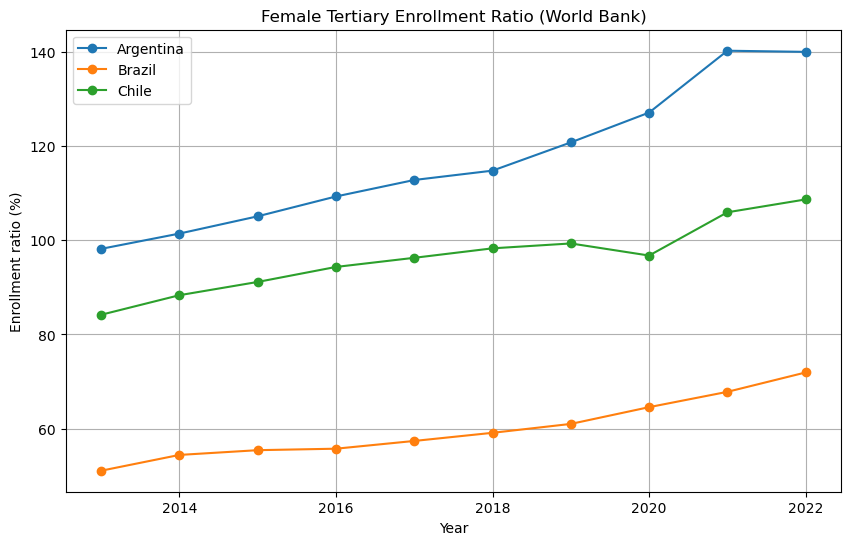

In [526]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for country in ["Argentina", "Brazil", "Chile"]:
    data = wb_daad.filter(pl.col("country") == country).sort("year")
    plt.plot(
        data["year"].to_numpy(),
        data["wb_attendance_ratio"].to_numpy(),
        marker="o",
        label=country
    )

plt.title("Female Tertiary Enrollment Ratio (World Bank)")
plt.xlabel("Year")
plt.ylabel("Enrollment ratio (%)")
plt.legend()
plt.grid(True)
plt.show()


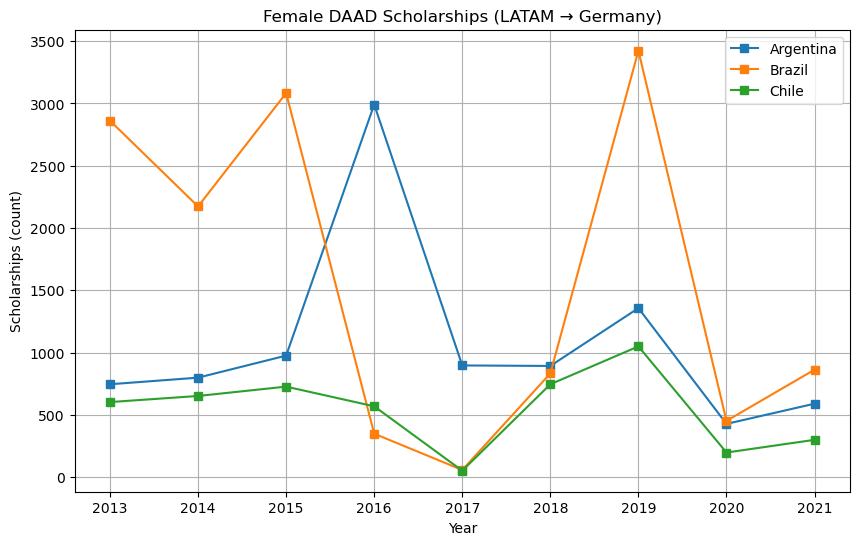

In [527]:
plt.figure(figsize=(10,6))

for country in ["Argentina", "Brazil", "Chile"]:
    data = wb_daad.filter(pl.col("country") == country).sort("year")
    plt.plot(
        data["year"].to_numpy(),
        data["daad_female_scholarships"].to_numpy(),
        marker="s",
        label=country
    )

plt.title("Female DAAD Scholarships (LATAM → Germany)")
plt.xlabel("Year")
plt.ylabel("Scholarships (count)")
plt.legend()
plt.grid(True)
plt.show()


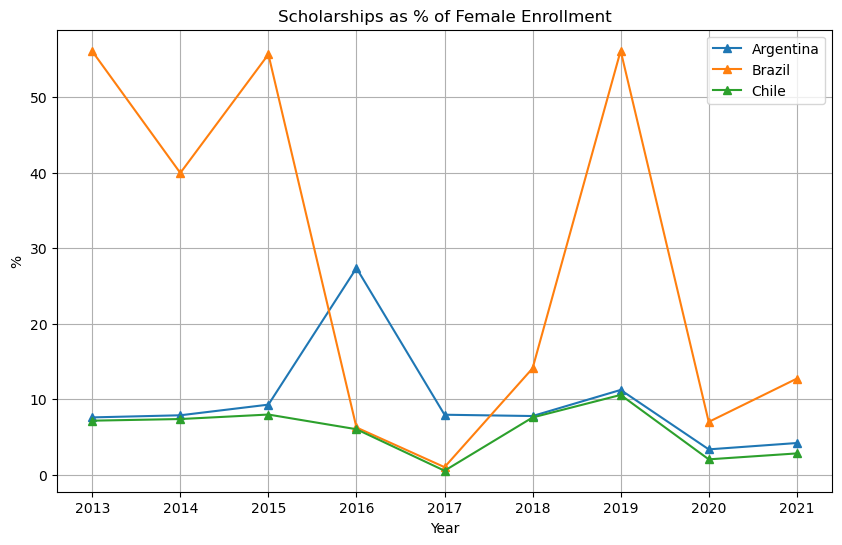

In [528]:
plt.figure(figsize=(10,6))

for country in ["Argentina", "Brazil", "Chile"]:
    data = wb_daad.filter(pl.col("country") == country).sort("year")
    plt.plot(
        data["year"].to_numpy(),
        data["share_scholarships_vs_enrollment"].to_numpy(),
        marker="^",
        label=country
    )

plt.title("Scholarships as % of Female Enrollment")
plt.xlabel("Year")
plt.ylabel("%")
plt.legend()
plt.grid(True)
plt.show()


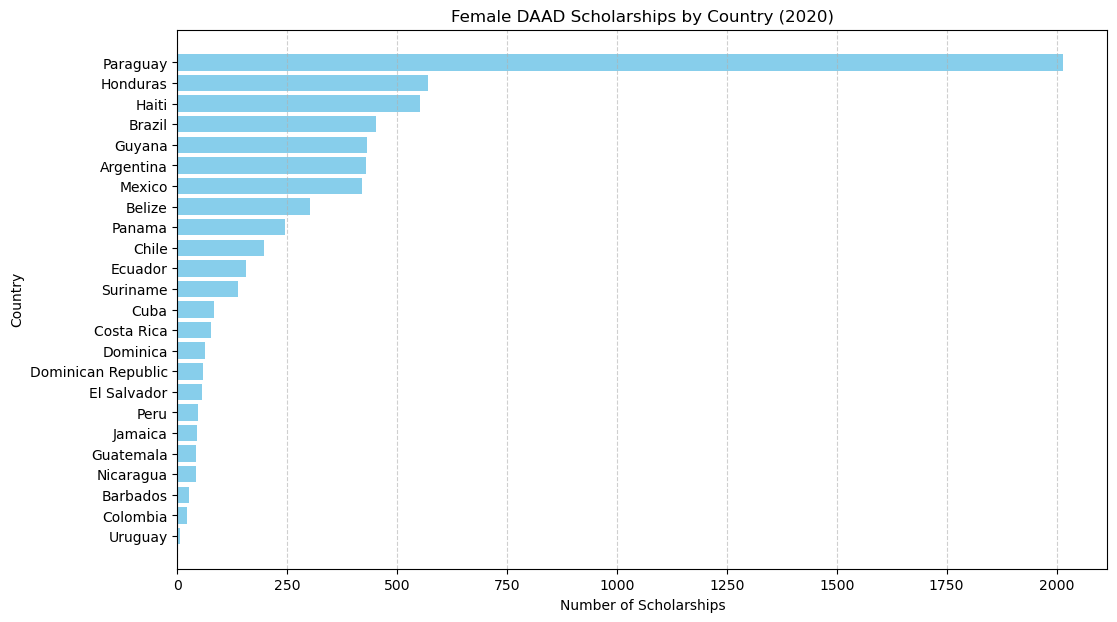

In [529]:
import matplotlib.pyplot as plt

# Pick a year for comparison
year_focus = 2020

# Filter and sort
data = (
    wb_daad.filter(pl.col("year") == year_focus)
           .select(["country", "daad_female_scholarships"])
           .drop_nulls()
           .sort("daad_female_scholarships", descending=True)
)

countries = data["country"].to_list()
values = data["daad_female_scholarships"].to_list()

# Plot
plt.figure(figsize=(12,7))
plt.barh(countries, values, color="skyblue")
plt.title(f"Female DAAD Scholarships by Country ({year_focus})")
plt.xlabel("Number of Scholarships")
plt.ylabel("Country")
plt.gca().invert_yaxis()  # biggest at the top
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.show()


## MERGING WB_DAAD WITH DESTATIS

In [530]:
## total arrivals
master = (
    wb_daad.join(
        destastis_year_foreign_fem,  
        on="year",
        how="left"
    )
    .rename({"destatis_foreign_female_total": "destatis_female_in_germany"})
)

print("Master funnel dataset")
print("Shape:", master.shape)
print(master.head(10))

Master funnel dataset
Shape: (230, 7)
shape: (10, 7)
┌───────────┬──────┬──────┬──────────────────┬─────────────────┬─────────────────┬─────────────────┐
│ country   ┆ iso3 ┆ year ┆ wb_attendance_ra ┆ daad_female_sch ┆ share_scholarsh ┆ destatis_female │
│ ---       ┆ ---  ┆ ---  ┆ tio              ┆ olarships       ┆ ips_vs_enrollme ┆ _in_germany     │
│ str       ┆ str  ┆ i64  ┆ ---              ┆ ---             ┆ …               ┆ ---             │
│           ┆      ┆      ┆ f64              ┆ i64             ┆ ---             ┆ i64             │
│           ┆      ┆      ┆                  ┆                 ┆ f64             ┆                 │
╞═══════════╪══════╪══════╪══════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ Argentina ┆ ARG  ┆ 2013 ┆ 98.193382        ┆ 746             ┆ 7.597253        ┆ 148675          │
│ Argentina ┆ ARG  ┆ 2014 ┆ 101.442146       ┆ 799             ┆ 7.876411        ┆ 158064          │
│ Argentina ┆ ARG  ┆ 2015 ┆ 105.110039

In [531]:
# Fix null years by forward-filling within the table
destatis_fields = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("field").cast(pl.Utf8).str.strip_chars().alias("field"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")  # propagate year downward
    )
    .select(["year", "field", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_field"})
)

print(" Destatis fields fixed")
print(destatis_fields.filter(pl.col("year") == 2024).head(20))


 Destatis fields fixed
shape: (20, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2024 ┆ Administration of Justice       ┆ 2                       │
│ 2024 ┆ Administrative Science/Public … ┆ 348                     │
│ 2024 ┆ Adult Education and Extracurri… ┆ 100                     │
│ 2024 ┆ Aeronautical and Aerospace Eng… ┆ 419                     │
│ 2024 ┆ African Studies                 ┆ 169                     │
│ …    ┆ …                               ┆ …                       │
│ 2024 ┆ Applied Systems Science         ┆ 442                     │
│ 2024 ┆ Arabic/Arabic Studies           ┆ 81                      │
│ 2024 ┆ Archaeology                     ┆ 347                   

In [532]:
destatis_degrees = (
    destatis_0004
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("degree").cast(pl.Utf8).str.strip_chars().alias("degree"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")
    )
    .select(["year", "degree", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_degree"})
)

print(" Destatis degrees fixed")
print(destatis_degrees.filter(pl.col("year") == 2024).head(20))


 Destatis degrees fixed
shape: (20, 3)
┌──────┬─────────────────────────────────┬──────────────────────────┐
│ year ┆ degree                          ┆ foreign_female_by_degree │
│ ---  ┆ ---                             ┆ ---                      │
│ i32  ┆ str                             ┆ i64                      │
╞══════╪═════════════════════════════════╪══════════════════════════╡
│ 2024 ┆ Administration of Justice       ┆ 2                        │
│ 2024 ┆ Administrative Science/Public … ┆ 348                      │
│ 2024 ┆ Adult Education and Extracurri… ┆ 100                      │
│ 2024 ┆ Aeronautical and Aerospace Eng… ┆ 419                      │
│ 2024 ┆ African Studies                 ┆ 169                      │
│ …    ┆ …                               ┆ …                        │
│ 2024 ┆ Applied Systems Science         ┆ 442                      │
│ 2024 ┆ Arabic/Arabic Studies           ┆ 81                       │
│ 2024 ┆ Archaeology                     ┆ 347     

In [533]:
# Merge WB+DAAD with fields
wb_fields = (
    wb_daad
    .join(destatis_fields, on="year", how="left")
)

# Merge WB+DAAD with degrees
wb_degrees = (
    wb_daad
    .join(destatis_degrees, on="year", how="left")
)

print("With fields:", wb_fields.shape)
print("With degrees:", wb_degrees.shape)


With fields: (230, 8)
With degrees: (230, 8)


In [534]:
print(wb_fields.filter(pl.col("year") == 2020).head(10))
print(wb_degrees.filter(pl.col("year") == 2020).head(10))


shape: (10, 8)
┌───────────────┬──────┬──────┬───────────────┬──────────────┬──────────────┬───────┬──────────────┐
│ country       ┆ iso3 ┆ year ┆ wb_attendance ┆ daad_female_ ┆ share_schola ┆ field ┆ foreign_fema │
│ ---           ┆ ---  ┆ ---  ┆ _ratio        ┆ scholarships ┆ rships_vs_en ┆ ---   ┆ le_by_field  │
│ str           ┆ str  ┆ i64  ┆ ---           ┆ ---          ┆ rollme…      ┆ str   ┆ ---          │
│               ┆      ┆      ┆ f64           ┆ i64          ┆ ---          ┆       ┆ i64          │
│               ┆      ┆      ┆               ┆              ┆ f64          ┆       ┆              │
╞═══════════════╪══════╪══════╪═══════════════╪══════════════╪══════════════╪═══════╪══════════════╡
│ Argentina     ┆ ARG  ┆ 2020 ┆ 127.155449    ┆ 428          ┆ 3.365959     ┆ null  ┆ null         │
│ Barbados      ┆ BRB  ┆ 2020 ┆ null          ┆ 27           ┆ null         ┆ null  ┆ null         │
│ Belize        ┆ BLZ  ┆ 2020 ┆ 32.770271     ┆ 301          ┆ 9.185154     

In [535]:
print(destatis_fields.filter(pl.col("year") == 2024).shape)
print(destatis_degrees.filter(pl.col("year") == 2024).shape)


(293, 3)
(293, 3)


In [536]:
print(wb_fields.filter(pl.col("country") == "Brazil").head(20))


shape: (11, 8)
┌─────────┬──────┬──────┬────────────────┬────────────────┬────────────────┬───────┬───────────────┐
│ country ┆ iso3 ┆ year ┆ wb_attendance_ ┆ daad_female_sc ┆ share_scholars ┆ field ┆ foreign_femal │
│ ---     ┆ ---  ┆ ---  ┆ ratio          ┆ holarships     ┆ hips_vs_enroll ┆ ---   ┆ e_by_field    │
│ str     ┆ str  ┆ i64  ┆ ---            ┆ ---            ┆ me…            ┆ str   ┆ ---           │
│         ┆      ┆      ┆ f64            ┆ i64            ┆ ---            ┆       ┆ i64           │
│         ┆      ┆      ┆                ┆                ┆ f64            ┆       ┆               │
╞═════════╪══════╪══════╪════════════════╪════════════════╪════════════════╪═══════╪═══════════════╡
│ Brazil  ┆ BRA  ┆ 2013 ┆ 51.04491       ┆ 2861           ┆ 56.048683      ┆ null  ┆ null          │
│ Brazil  ┆ BRA  ┆ 2014 ┆ 54.402191      ┆ 2173           ┆ 39.943244      ┆ null  ┆ null          │
│ Brazil  ┆ BRA  ┆ 2015 ┆ 55.410389      ┆ 3083           ┆ 55.639386      ┆

In [537]:
wb_fields.group_by("field").agg(pl.col("foreign_female_by_field").sum())


field,foreign_female_by_field
str,i64
null,0


In [538]:
# Merge WB + DAAD on country + year
wb_daad = (
    wb_latam
    .join(daad_female, on=["country", "iso3", "year"], how="inner")
    .with_columns(
        (pl.col("daad_female_scholarships") / pl.col("wb_attendance_ratio"))
        .alias("share_scholarships_vs_enrollment")
    )
)

print("Country-level (WB + DAAD):", wb_daad.shape)
print(wb_daad.head(10))


Country-level (WB + DAAD): (230, 6)
shape: (10, 6)
┌────────────────────┬──────┬──────┬─────────────────────┬────────────────────┬────────────────────┐
│ country            ┆ iso3 ┆ year ┆ wb_attendance_ratio ┆ daad_female_schola ┆ share_scholarships │
│ ---                ┆ ---  ┆ ---  ┆ ---                 ┆ rships             ┆ _vs_enrollme…      │
│ str                ┆ str  ┆ i64  ┆ f64                 ┆ ---                ┆ ---                │
│                    ┆      ┆      ┆                     ┆ i64                ┆ f64                │
╞════════════════════╪══════╪══════╪═════════════════════╪════════════════════╪════════════════════╡
│ Argentina          ┆ ARG  ┆ 2013 ┆ 98.193382           ┆ 746                ┆ 7.597253           │
│ Brazil             ┆ BRA  ┆ 2013 ┆ 51.04491            ┆ 2861               ┆ 56.048683          │
│ Chile              ┆ CHL  ┆ 2013 ┆ 84.185921           ┆ 603                ┆ 7.162718           │
│ Colombia           ┆ COL  ┆ 2013 ┆ 53.

In [539]:
# Fields pipeline
destatis_fields = (
    destatis_0003
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("field").cast(pl.Utf8).str.strip_chars().alias("field"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")
    )
    .select(["year", "field", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_field"})
)

print("Fields:", destatis_fields.shape)
print(destatis_fields.head(10))


# Degrees pipeline
destatis_degrees = (
    destatis_0004
    .with_columns([
        extract_year("year").alias("year"),
        pl.col("degree").cast(pl.Utf8).str.strip_chars().alias("degree"),
        to_int("foreigners_female")
    ])
    .with_columns(
        pl.col("year").fill_null(strategy="forward")
    )
    .select(["year", "degree", "foreigners_female"])
    .rename({"foreigners_female": "foreign_female_by_degree"})
)

print("Degrees:", destatis_degrees.shape)
print(destatis_degrees.head(10))


Fields: (293, 3)
shape: (10, 3)
┌──────┬─────────────────────────────────┬─────────────────────────┐
│ year ┆ field                           ┆ foreign_female_by_field │
│ ---  ┆ ---                             ┆ ---                     │
│ i32  ┆ str                             ┆ i64                     │
╞══════╪═════════════════════════════════╪═════════════════════════╡
│ 2024 ┆ Administration of Justice       ┆ 2                       │
│ 2024 ┆ Administrative Science/Public … ┆ 348                     │
│ 2024 ┆ Adult Education and Extracurri… ┆ 100                     │
│ 2024 ┆ Aeronautical and Aerospace Eng… ┆ 419                     │
│ 2024 ┆ African Studies                 ┆ 169                     │
│ 2024 ┆ Agricultural Biology            ┆ 308                     │
│ 2024 ┆ Agricultural Economics          ┆ 361                     │
│ 2024 ┆ Agricultural Science/Agricultu… ┆ 1253                    │
│ 2024 ┆ American Studies                ┆ 830                     │
│ 

In [540]:
# === EXPORT COUNTRY-LEVEL (WB + DAAD) ===
wb_daad.write_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/wb_daad_country.csv"
)

# === EXPORT GERMANY FIELDS ===
destatis_fields.write_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/destatis_fields.csv"
)

# === EXPORT GERMANY DEGREES ===
destatis_degrees.write_csv(
    "/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs/destatis_degrees.csv"
)

print(" All three CSVs exported for Tableau!")


 All three CSVs exported for Tableau!


## ANSWERING THE QUESTION

In [541]:
BASE = '/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/outputs'
wb_daad = pl.read_csv(f'{BASE}/wb_daad_country.csv')  
fields  = pl.read_csv(f'{BASE}/destatis_fields_foreign_female.csv')  
degrees = pl.read_csv(f'{BASE}/destatis_degrees_foreign_female.csv') 

print(wb_daad.shape, fields.shape, degrees.shape)

(230, 6) (293, 3) (293, 3)


In [542]:
## DOUBLE CHECKING TYPES
wb_daad = wb_daad.with_columns([
    pl.col("year").cast(pl.Int64, strict=False),
    pl.col("wb_attendance_ratio").cast(pl.Float64, strict=False),
    pl.col("daad_female_scholarships").cast(pl.Int64, strict=False),
    pl.col("share_scholarships_vs_enrollment").cast(pl.Float64, strict=False),
])

fields = fields.with_columns([
    pl.col("year").cast(pl.Int64, strict=False),
    pl.col("foreign_female_by_field").cast(pl.Int64, strict=False),
])

degrees = degrees.with_columns([
    pl.col("year").cast(pl.Int64, strict=False),
    pl.col("foreign_female_by_degree").cast(pl.Int64, strict=False),
])

print(wb_daad.schema)
print(fields.schema)
print(degrees.schema)


Schema({'country': String, 'iso3': String, 'year': Int64, 'wb_attendance_ratio': Float64, 'daad_female_scholarships': Int64, 'share_scholarships_vs_enrollment': Float64})
Schema({'year': Int64, 'field': String, 'foreign_female_by_field': Int64})
Schema({'year': Int64, 'degree': String, 'foreign_female_by_degree': Int64})


In [543]:
wb_daad = wb_daad.filter(pl.col("year").is_between(2013, 2023))


In [544]:
top_send = (
    wb_daad
    .group_by("country","iso3")
    .agg(pl.col("daad_female_scholarships").sum().alias("total_scholarships"))
    .sort("total_scholarships", descending=True)
)
print(top_send.head(15))


shape: (15, 3)
┌────────────────────┬──────┬────────────────────┐
│ country            ┆ iso3 ┆ total_scholarships │
│ ---                ┆ ---  ┆ ---                │
│ str                ┆ str  ┆ i64                │
╞════════════════════╪══════╪════════════════════╡
│ Brazil             ┆ BRA  ┆ 14095              │
│ Argentina          ┆ ARG  ┆ 9677               │
│ Paraguay           ┆ PRY  ┆ 7469               │
│ Panama             ┆ PAN  ┆ 7351               │
│ Mexico             ┆ MEX  ┆ 5939               │
│ …                  ┆ …    ┆ …                  │
│ Jamaica            ┆ JAM  ┆ 2644               │
│ Ecuador            ┆ ECU  ┆ 2492               │
│ Dominican Republic ┆ DOM  ┆ 2443               │
│ Guatemala          ┆ GTM  ┆ 1776               │
│ Costa Rica         ┆ CRI  ┆ 1740               │
└────────────────────┴──────┴────────────────────┘


## Q: HOW HAS FEMALE TERTIARY ENROLLMENT IN LATIN AMERICA (2013-2023)

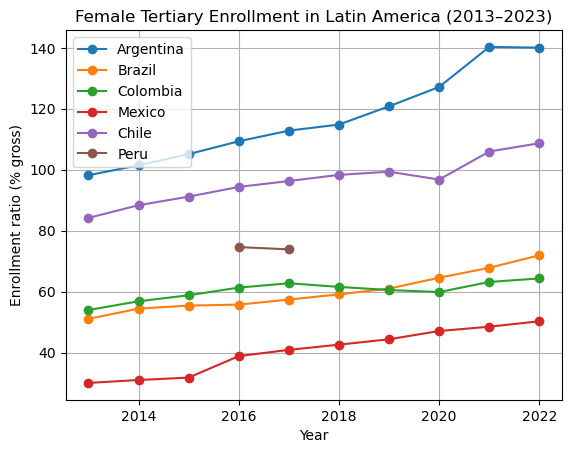

In [545]:
import matplotlib.pyplot as plt

# Step 1. Filter for key countries
main_countries = ["Argentina", "Brazil", "Colombia", "Mexico", "Chile", "Peru"]
subset = wb_latam.filter(pl.col("country").is_in(main_countries))

# Step 2. Group and collect values year by year
for country in main_countries:
    country_data = subset.filter(pl.col("country") == country).sort("year")
    years = country_data["year"].to_list()
    ratios = country_data["wb_attendance_ratio"].to_list()
    plt.plot(years, ratios, marker="o", label=country)

# Step 3. Chart formatting
plt.title("Female Tertiary Enrollment in Latin America (2013–2023)")
plt.xlabel("Year")
plt.ylabel("Enrollment ratio (% gross)")
plt.legend()
plt.grid(True)
plt.show()


## Q: HOW MANY SCHOLARSHIPS DO LATINA WOMEN ACTUALLY WIN, AND HOW DOES THIS COMPARE ACROSS COUNTRIES?

In [546]:
# Aggregate female scholarships by country
daad_by_country = (
    wb_daad.group_by("country")
    .agg(pl.col("daad_female_scholarships").sum().alias("total_scholarships"))
    .sort("total_scholarships", descending=True)
)

print(daad_by_country.head(10))


shape: (10, 2)
┌───────────┬────────────────────┐
│ country   ┆ total_scholarships │
│ ---       ┆ ---                │
│ str       ┆ i64                │
╞═══════════╪════════════════════╡
│ Brazil    ┆ 14095              │
│ Argentina ┆ 9677               │
│ Paraguay  ┆ 7469               │
│ Panama    ┆ 7351               │
│ Mexico    ┆ 5939               │
│ Chile     ┆ 4897               │
│ Cuba      ┆ 4542               │
│ Belize    ┆ 3252               │
│ Colombia  ┆ 3191               │
│ Peru      ┆ 2924               │
└───────────┴────────────────────┘


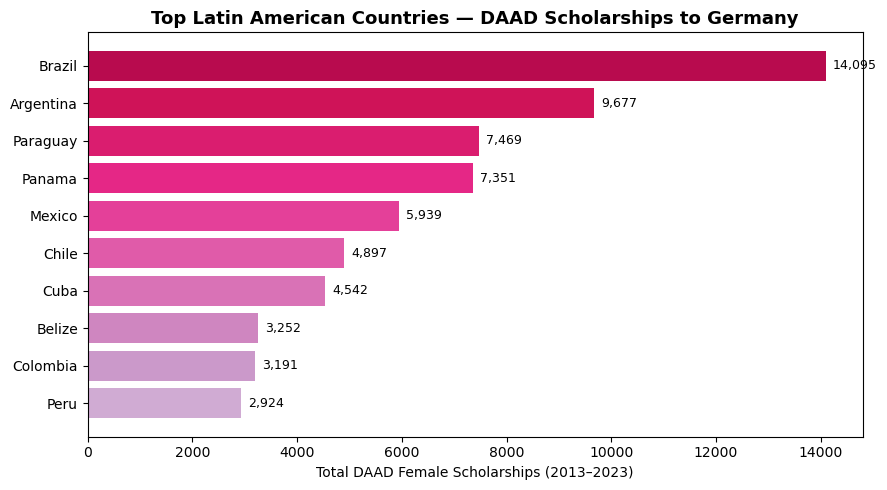

In [547]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

top_countries = daad_by_country.head(10)

vals = top_countries["total_scholarships"].to_list()[::-1]
labels = top_countries["country"].to_list()[::-1]

# Generate pastel pink–purple colors
colors = cm.PuRd(np.linspace(0.3, 0.8, len(vals)))  # softer gradient

plt.figure(figsize=(9,5))
bars = plt.barh(labels, vals, color=colors)

# Add values on bars
for bar, val in zip(bars, vals):
    plt.text(val + max(vals)*0.01,  # offset a little to the right
             bar.get_y() + bar.get_height()/2,
             f"{val:,}",            # add commas for readability
             va="center", ha="left",
             fontsize=9, color="black")

plt.xlabel("Total DAAD Female Scholarships (2013–2023)")
plt.title("Top Latin American Countries — DAAD Scholarships to Germany", fontsize=13, weight="bold")

plt.tight_layout()
plt.show()

## This tells us not just who sends the most women, but who has the best odds relative to their student base.

In [548]:
# Average attendance ratio per country (proxy for size of tertiary female student base)
enrollment_avg = (
    wb_daad.group_by("country")
    .agg(pl.col("wb_attendance_ratio").mean().alias("avg_enrollment_ratio"))
)

# Total scholarships per country
scholarships_total = (
    wb_daad.group_by("country")
    .agg(pl.col("daad_female_scholarships").sum().alias("total_scholarships"))
)

# Merge
fairness = scholarships_total.join(enrollment_avg, on="country", how="inner")

# Scholarships per 100k enrolled
fairness = fairness.with_columns(
    (pl.col("total_scholarships") / pl.col("avg_enrollment_ratio") * 1e5).alias("scholarships_per_100k")
)

print(fairness.sort("scholarships_per_100k", descending=True).head(10))


shape: (10, 4)
┌──────────┬────────────────────┬──────────────────────┬───────────────────────┐
│ country  ┆ total_scholarships ┆ avg_enrollment_ratio ┆ scholarships_per_100k │
│ ---      ┆ ---                ┆ ---                  ┆ ---                   │
│ str      ┆ i64                ┆ f64                  ┆ f64                   │
╞══════════╪════════════════════╪══════════════════════╪═══════════════════════╡
│ Barbados ┆ 452                ┆ null                 ┆ null                  │
│ Paraguay ┆ 7469               ┆ null                 ┆ null                  │
│ Dominica ┆ 339                ┆ null                 ┆ null                  │
│ Guyana   ┆ 1051               ┆ null                 ┆ null                  │
│ Suriname ┆ 363                ┆ null                 ┆ null                  │
│ Haiti    ┆ 917                ┆ null                 ┆ null                  │
│ Jamaica  ┆ 2644               ┆ null                 ┆ null                  │
│ Brazil   ┆ 

/var/folders/vq/6bh1xs4j65q7bltc_wqn_ps40000gn/T/ipykernel_69037/85174359.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Purples")(np.linspace(0.4, 0.9, len(values)))


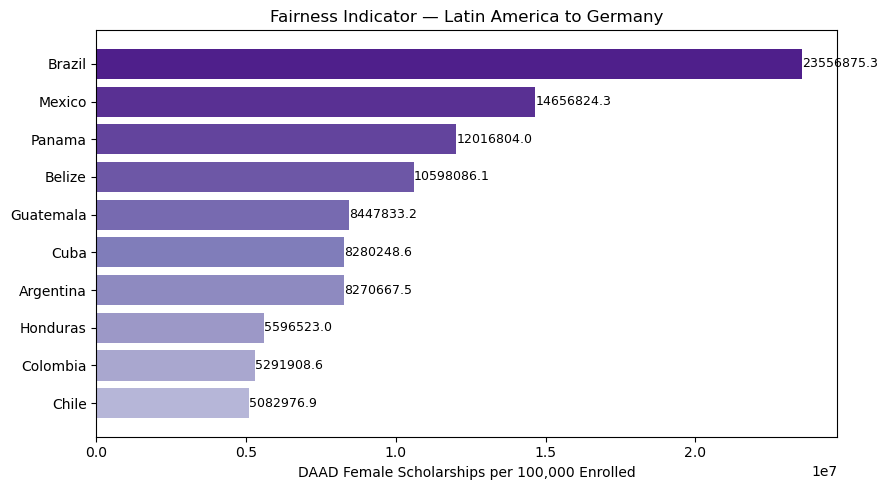

In [549]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Drop rows where scholarships_per_100k is null
fair_top = (
    fairness
    .drop_nulls(["scholarships_per_100k"])
    .sort("scholarships_per_100k", descending=True)
    .head(10)
)

countries = fair_top["country"].to_list()[::-1]
values = fair_top["scholarships_per_100k"].to_list()[::-1]

# Purple gradient (lighter → darker)
colors = cm.get_cmap("Purples")(np.linspace(0.4, 0.9, len(values)))

plt.figure(figsize=(9,5))
bars = plt.barh(countries, values, color=colors)

# Labels on bars
for bar, val in zip(bars, values):
    plt.text(val + 0.5,  # a little to the right of the bar
             bar.get_y() + bar.get_height()/2,
             f"{val:.1f}",
             va='center',
             fontsize=9,
             color="black")

plt.xlabel("DAAD Female Scholarships per 100,000 Enrolled")
plt.title("Fairness Indicator — Latin America to Germany")
plt.tight_layout()
plt.show()


## When scaled by enrollment size, scholarship opportunities appear uneven. Countries like Uruguay or Chile punch above their weight, while larger systems (e.g., Brazil, Mexico) send fewer per capita.

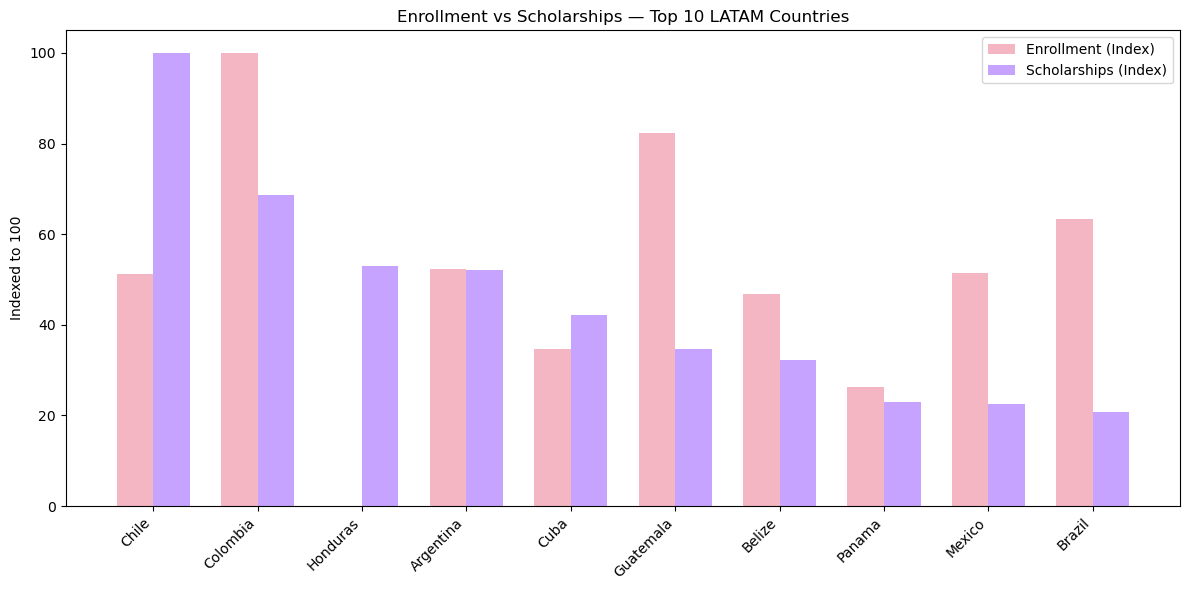

In [550]:
# Replace None with 0 before normalization
enrollment = [e if e is not None else 0 for e in enrollment]
scholarships = [s if s is not None else 0 for s in scholarships]

# Normalize both to index 100
enroll_norm = [e / max(enrollment) * 100 if max(enrollment) > 0 else 0 for e in enrollment]
schol_norm = [s / max(scholarships) * 100 if max(scholarships) > 0 else 0 for s in scholarships]

x = np.arange(len(countries))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, enroll_norm, width, label="Enrollment (Index)", color="#f4b6c2")  
plt.bar(x + width/2, schol_norm, width, label="Scholarships (Index)", color="#c5a3ff")

plt.xticks(x, countries, rotation=45, ha="right")
plt.ylabel("Indexed to 100")
plt.title("Enrollment vs Scholarships — Top 10 LATAM Countries")
plt.legend()
plt.tight_layout()
plt.show()


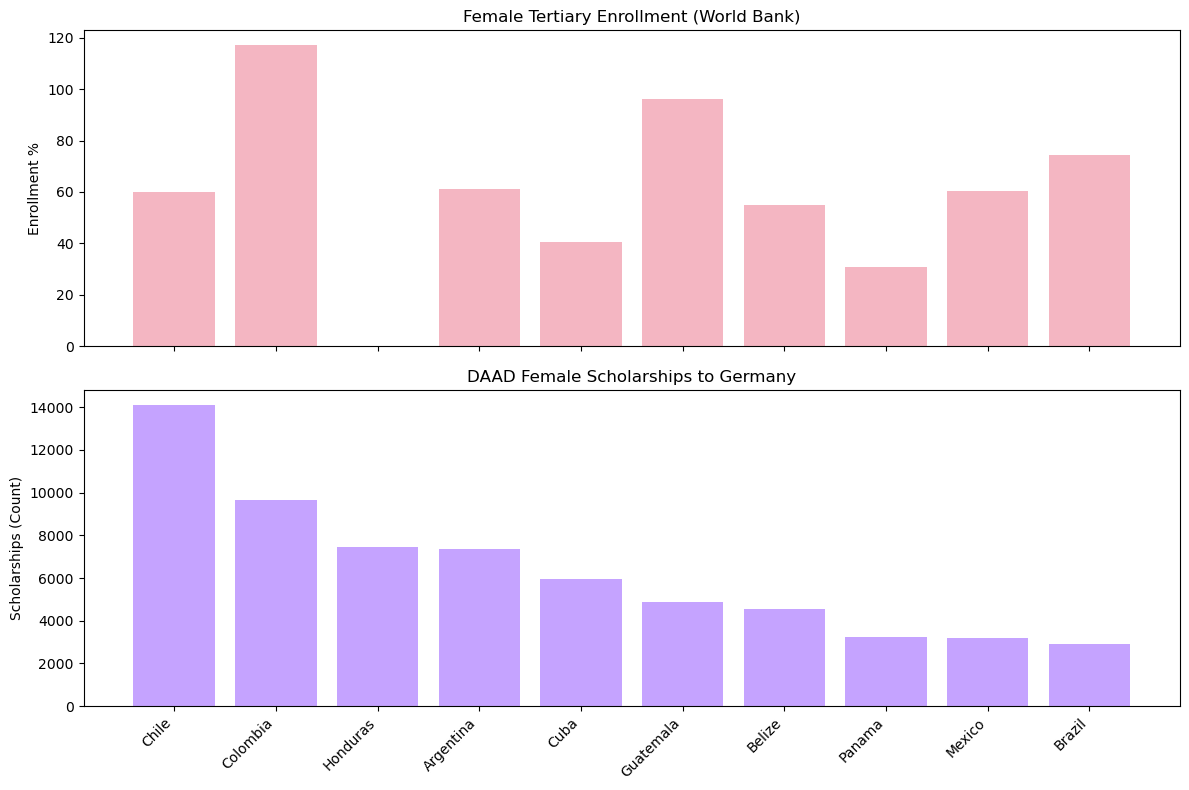

In [551]:
# Replace None with 0 (or drop them if you prefer)
enrollment = [e if e is not None else 0 for e in enrollment]
scholarships = [s if s is not None else 0 for s in scholarships]

fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# Enrollment
axes[0].bar(countries, enrollment, color="#f4b6c2")
axes[0].set_ylabel("Enrollment %")
axes[0].set_title("Female Tertiary Enrollment (World Bank)")

# Scholarships
axes[1].bar(countries, scholarships, color="#c5a3ff")
axes[1].set_ylabel("Scholarships (Count)")
axes[1].set_title("DAAD Female Scholarships to Germany")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Despite large numbers of women entering tertiary education in Latin America, only a small fraction receive DAAD scholarships to Germany. Argentina, Brazil, and Colombia dominate, but the gap is wide everywhere.

## WHICH FIELDS IN GERMANY ATTRACT THE MOST LATNA STUDENTS?

In [552]:
latest_year = destatis_fields.select(pl.max("year")).item()
print("Latest year:", latest_year)


Latest year: 2024


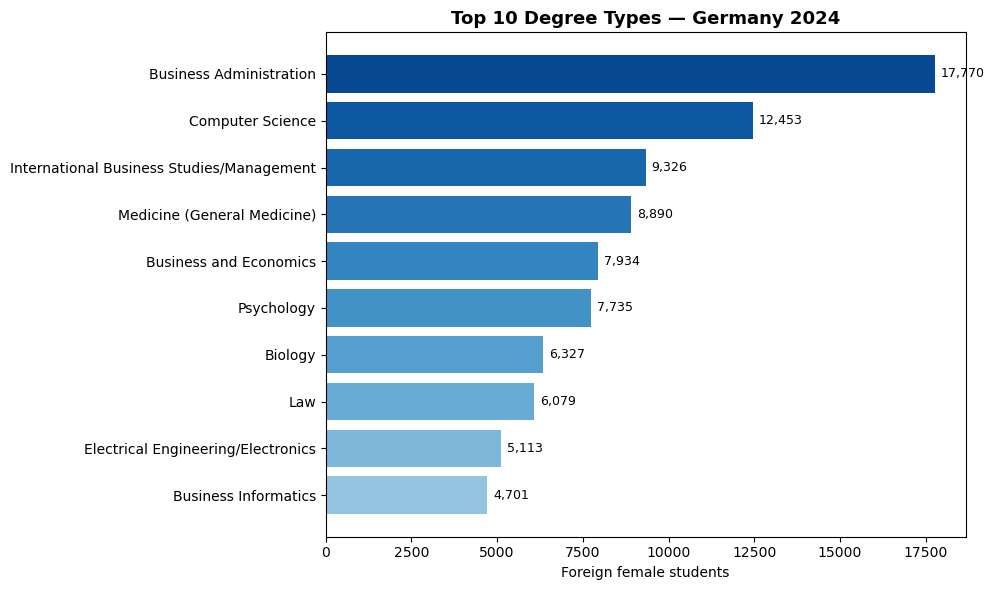

In [554]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Degrees
vals = top_degrees["foreign_female_by_degree"].to_list()[::-1]  # reverse for top-down
labels = top_degrees["degree"].to_list()[::-1]

# Blue gradient (pastel range)
colors = cm.Blues(np.linspace(0.4, 0.9, len(vals)))

plt.figure(figsize=(10,6))
bars = plt.barh(labels, vals, color=colors)

# Add value labels
for bar, val in zip(bars, vals):
    plt.text(val + max(vals)*0.01,
             bar.get_y() + bar.get_height()/2,
             f"{val:,}",
             va="center", ha="left",
             fontsize=9, color="black")

plt.xlabel("Foreign female students")
plt.title(f"Top 10 Degree Types — Germany {latest_year}", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


## Q:HOW HAS THINGS CHANNGED OVER TIME?

In [555]:
trend = (
    wb_daad
    .group_by("year")  
    .agg([
        pl.col("daad_female_scholarships").sum().alias("total_scholarships"),
        pl.col("wb_attendance_ratio").mean().alias("avg_enrollment_ratio"),
    ])
    .sort("year")
)

print(trend)


shape: (11, 3)
┌──────┬────────────────────┬──────────────────────┐
│ year ┆ total_scholarships ┆ avg_enrollment_ratio │
│ ---  ┆ ---                ┆ ---                  │
│ i64  ┆ i64                ┆ f64                  │
╞══════╪════════════════════╪══════════════════════╡
│ 2013 ┆ 8045               ┆ 47.539686            │
│ 2014 ┆ 7365               ┆ 49.694543            │
│ 2015 ┆ 8910               ┆ 51.048607            │
│ 2016 ┆ 12465              ┆ 52.16296             │
│ 2017 ┆ 4706               ┆ 56.902311            │
│ …    ┆ …                  ┆ …                    │
│ 2019 ┆ 10941              ┆ 54.800065            │
│ 2020 ┆ 6473               ┆ 58.258755            │
│ 2021 ┆ 6610               ┆ 68.017407            │
│ 2022 ┆ 0                  ┆ 68.455884            │
│ 2023 ┆ 0                  ┆ 39.245361            │
└──────┴────────────────────┴──────────────────────┘


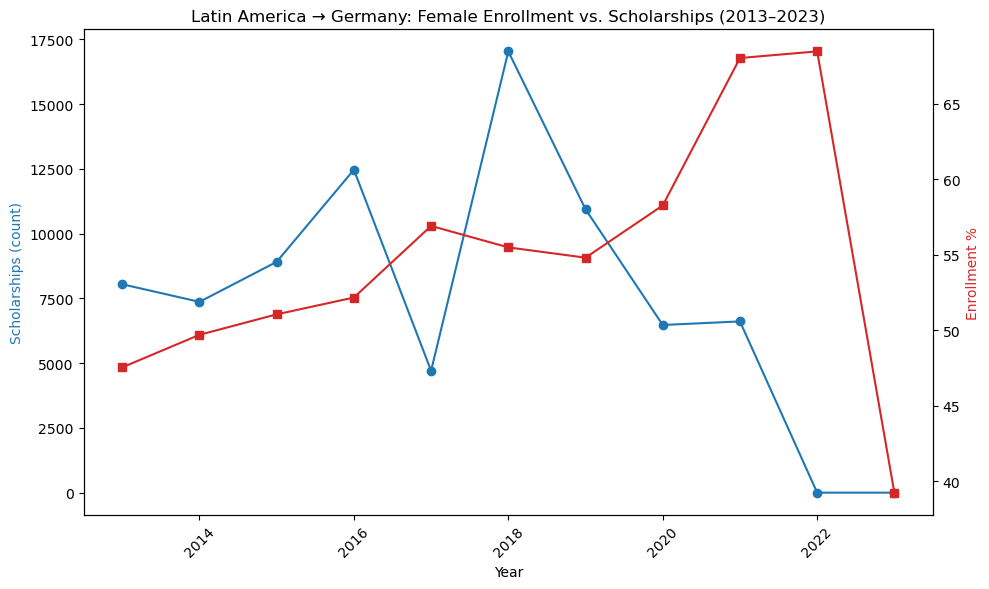

In [556]:
plt.figure(figsize=(10,6))

# Scholarships line
plt.plot(trend["year"], trend["total_scholarships"], marker="o", label="DAAD Female Scholarships", color="tab:blue")
plt.ylabel("Scholarships (count)", color="tab:blue")
plt.xlabel("Year")
plt.xticks(rotation=45)

# Enrollment line (secondary y-axis)
ax2 = plt.gca().twinx()
ax2.plot(trend["year"], trend["avg_enrollment_ratio"], marker="s", color="tab:red", label="Avg Enrollment Ratio (LATAM)")
ax2.set_ylabel("Enrollment %", color="tab:red")

plt.title("Latin America → Germany: Female Enrollment vs. Scholarships (2013–2023)")
plt.tight_layout()
plt.show()


## How many female students migrate to Germany each year, and what is the growth rate?

In [557]:
import re
import matplotlib.pyplot as plt

# --- helpers ---
def extract_year_expr(col: str = "year"):
    # pull the first 4-digit year (handles "WT 2024/25" etc.)
    return pl.col(col).cast(pl.Utf8).str.extract(r"(\d{4})").cast(pl.Int32)

def to_int(col: str):
    return (
        pl.col(col)
        .cast(pl.Utf8)
        .str.replace_all(",", "")
        .cast(pl.Int64, strict=False)
    )


In [558]:
path_0001 = '/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv'
d1 = pl.read_csv(path_0001)

In [559]:
print("Cols:", d1.columns[:10])

Cols: ['year', 'germans_male', 'germans_female', 'germans_total', 'foreigners_male', 'foreigners_female', 'foreigners_total', 'total_male', 'total_female', 'total_total']


In [560]:
trend = (
    d1
    .with_columns([
        extract_year_expr("year").alias("year"),
        to_int("foreigners_female")
    ])
    .select(["year", "foreigners_female"])
    .drop_nulls("year")
    .group_by("year").agg(pl.col("foreigners_female").sum().alias("foreigners_female"))
    .sort("year")
)

# add lagged column separately
trend = trend.with_columns(
    pl.col("foreigners_female").shift(1).alias("prev")
)

# compute yoy growth
trend = trend.with_columns(
    (((pl.col("foreigners_female") - pl.col("prev")) / pl.col("prev")) * 100.0)
    .alias("yoy_growth_pct")
)

print(trend)


shape: (27, 4)
┌──────┬───────────────────┬────────┬────────────────┐
│ year ┆ foreigners_female ┆ prev   ┆ yoy_growth_pct │
│ ---  ┆ ---               ┆ ---    ┆ ---            │
│ i32  ┆ i64               ┆ i64    ┆ f64            │
╞══════╪═══════════════════╪════════╪════════════════╡
│ 1998 ┆ 73673             ┆ null   ┆ null           │
│ 1999 ┆ 79605             ┆ 73673  ┆ 8.051796       │
│ 2000 ┆ 87121             ┆ 79605  ┆ 9.441618       │
│ 2001 ┆ 98410             ┆ 87121  ┆ 12.95784       │
│ 2002 ┆ 109821            ┆ 98410  ┆ 11.595366      │
│ …    ┆ …                 ┆ …      ┆ …              │
│ 2020 ┆ 193470            ┆ 193586 ┆ -0.059922      │
│ 2021 ┆ 205538            ┆ 193470 ┆ 6.23766        │
│ 2022 ┆ 213717            ┆ 205538 ┆ 3.979313       │
│ 2023 ┆ 218651            ┆ 213717 ┆ 2.308661       │
│ 2024 ┆ 227670            ┆ 218651 ┆ 4.124838       │
└──────┴───────────────────┴────────┴────────────────┘


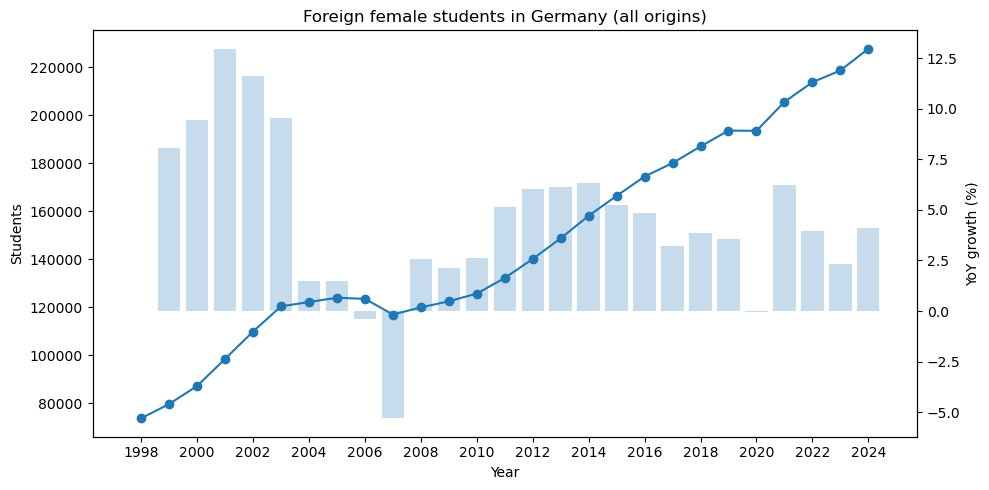

Latest: 2024 • students=227,670 • YoY=4.1%


In [561]:
years = trend["year"].to_list()
vals  = trend["foreigners_female"].to_list()
yoy   = [v if v is not None else 0 for v in trend["yoy_growth_pct"].to_list()]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(years, vals, marker="o")
ax.set_title("Foreign female students in Germany (all origins)")
ax.set_xlabel("Year")
ax.set_ylabel("Students")

ax2 = ax.twinx()
ax2.bar(years, yoy, alpha=0.25)
ax2.set_ylabel("YoY growth (%)")

ax.set_xticks(years[:: max(1, len(years)//10) ])
plt.tight_layout()
plt.show()

latest = trend.tail(1)
if latest.height:
    print(
        f"Latest: {latest['year'][0]} • students={latest['foreigners_female'][0]:,} "
        f"• YoY={latest['yoy_growth_pct'][0]:.1f}%"
    )


In [566]:
latam_total = wb_daad.select(pl.sum("daad_female_scholarships")).item()
global_total = d1.select(pl.sum("foreigners_female")).item()

share = (latam_total / global_total) * 100
print(f"LATAM share: {share:.2f}%")


LATAM share: 2.08%


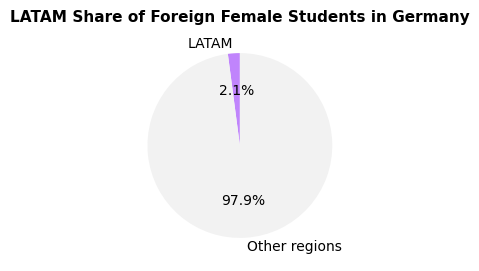

In [567]:
import matplotlib.pyplot as plt

# Data
labels = ["LATAM", "Other regions"]
sizes = [2.08, 97.92]
colors = ["#c084fc", "#f2f2f2"]  # pastel purple vs light gray

# Create pie
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(
    sizes, labels=labels, autopct="%.1f%%",
    startangle=90, colors=colors, textprops={"fontsize": 10}
)
ax.set_title("LATAM Share of Foreign Female Students in Germany", fontsize=11, weight="bold")
plt.show()


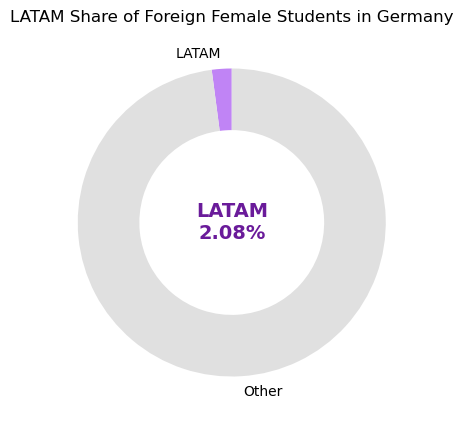

In [568]:
import matplotlib.pyplot as plt

# Values
latam_share = 2.08
rest_share = 100 - latam_share

# Donut chart
fig, ax = plt.subplots(figsize=(5,5))
wedges, texts, autotexts = ax.pie(
    [latam_share, rest_share],
    labels=["LATAM", "Other"],
    colors=["#c084f5", "#e0e0e0"],
    autopct="",
    startangle=90,
    wedgeprops=dict(width=0.4)  # creates donut
)

# Add annotation inside
plt.text(0, 0, f"LATAM\n{latam_share:.2f}%", 
         ha="center", va="center", fontsize=14, weight="bold", color="#6a1b9a")

plt.title("LATAM Share of Foreign Female Students in Germany")
plt.show()


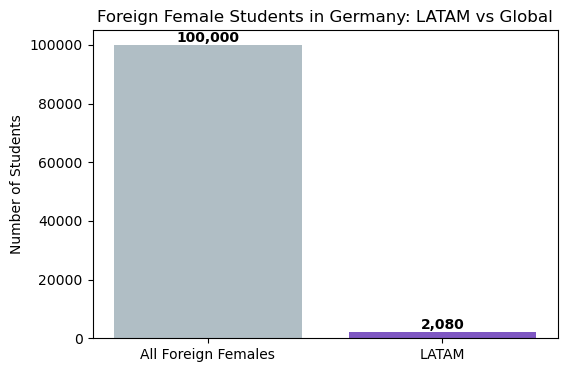

In [569]:
import matplotlib.pyplot as plt

# Example absolute numbers (replace with your dataset if you want real values)
total_foreign = 100000  # placeholder
latam_students = int(total_foreign * latam_share / 100)

fig, ax = plt.subplots(figsize=(6,4))

bars = ax.bar(["All Foreign Females", "LATAM"], 
              [total_foreign, latam_students],
              color=["#b0bec5", "#7e57c2"])

# Add labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}", 
            ha="center", va="bottom", fontsize=10, weight="bold")

ax.set_ylabel("Number of Students")
ax.set_title("Foreign Female Students in Germany: LATAM vs Global")
plt.show()


## how many women start tertiary education in LATAM vs. how few reach Germany via DAAD.

In [562]:
wb_da = (
    wb_latam
    .join(daad_female, on=["country", "iso3", "year"], how="inner")
    .with_columns([
        (pl.col("daad_female_scholarships") / (pl.col("wb_attendance_ratio") + 1e-9) * 1e5)
        .alias("scholarships_per_100k_enrolled")
    ])
)

print(wb_da.head(10))


shape: (10, 6)
┌────────────────────┬──────┬──────┬─────────────────────┬────────────────────┬────────────────────┐
│ country            ┆ iso3 ┆ year ┆ wb_attendance_ratio ┆ daad_female_schola ┆ scholarships_per_1 │
│ ---                ┆ ---  ┆ ---  ┆ ---                 ┆ rships             ┆ 00k_enrolled       │
│ str                ┆ str  ┆ i64  ┆ f64                 ┆ ---                ┆ ---                │
│                    ┆      ┆      ┆                     ┆ i64                ┆ f64                │
╞════════════════════╪══════╪══════╪═════════════════════╪════════════════════╪════════════════════╡
│ Argentina          ┆ ARG  ┆ 2013 ┆ 98.193382           ┆ 746                ┆ 759725.332602      │
│ Brazil             ┆ BRA  ┆ 2013 ┆ 51.04491            ┆ 2861               ┆ 5.6049e6           │
│ Chile              ┆ CHL  ┆ 2013 ┆ 84.185921           ┆ 603                ┆ 716271.788524      │
│ Colombia           ┆ COL  ┆ 2013 ┆ 53.959259           ┆ 495              

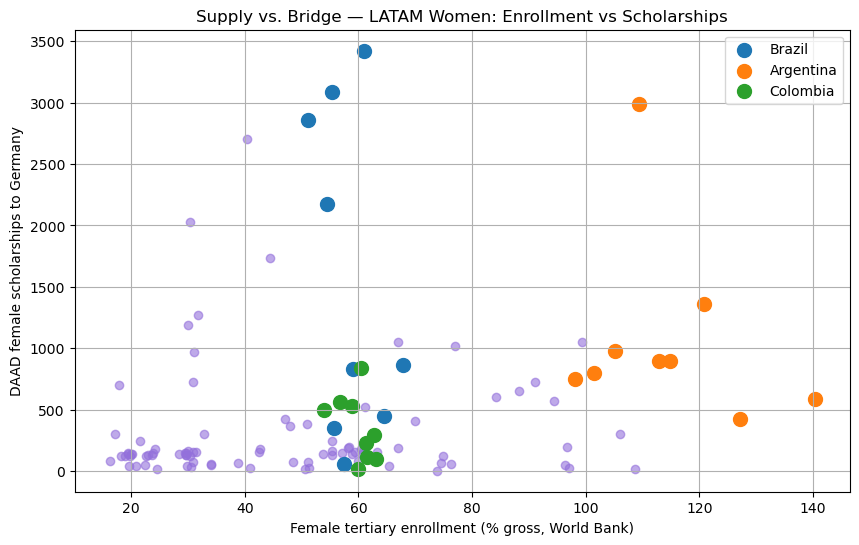

In [563]:
import matplotlib.pyplot as plt

# Extract values directly from Polars
x = wb_da["wb_attendance_ratio"].to_list()
y = wb_da["daad_female_scholarships"].to_list()
countries = wb_da["country"].to_list()

plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.6, color="mediumpurple")

# highlight a few key countries
highlight = ["Brazil", "Argentina", "Colombia"]
for c in highlight:
    mask = [ctry == c for ctry in countries]
    plt.scatter(
        [x[i] for i in range(len(x)) if mask[i]],
        [y[i] for i in range(len(y)) if mask[i]],
        s=100, label=c
    )

plt.xlabel("Female tertiary enrollment (% gross, World Bank)")
plt.ylabel("DAAD female scholarships to Germany")
plt.title("Supply vs. Bridge — LATAM Women: Enrollment vs Scholarships")
plt.legend()
plt.grid(True)
plt.show()


In [564]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt


def extract_year_expr(col):
    return pl.col(col).cast(pl.Utf8).str.extract(r"(\d{4})").cast(pl.Int64)

def to_int(col):
    return (
        pl.col(col)
        .cast(pl.Utf8)                         
        .str.replace_all(",", "")              
        .cast(pl.Int64, strict=False)          
        .alias(col)
    )


d1 = pl.read_csv("/Users/jhenifheralmeida/DA BOOTCAMP/FINAL PROJECT/Final_project/destatis_0001_clean.csv")


ts = (
    d1.with_columns([
        extract_year_expr("year").alias("year"),
        to_int("foreigners_female")
    ])
    .select(["year", "foreigners_female"])
    .drop_nulls("year")
    .group_by("year")
    .agg(pl.col("foreigners_female").sum().alias("foreigners_female"))
    .sort("year")
)

print(ts)

# Convert to plain Python lists
years = [int(y) for y in ts["year"].to_list()]
vals  = [float(v) if v is not None else np.nan for v in ts["foreigners_female"].to_list()]

# Filter out NaNs for fitting
mask = ~np.isnan(vals)
x = np.array(years)[mask]
y = np.array(vals)[mask]


if len(x) < 3:
    print("Not enough points to fit a trend.")
else:
   
    m, b = np.polyfit(x, y, 1) 

    last_year = int(np.nanmax(years))
    future_years = np.arange(last_year + 1, last_year + 6)
    y_forecast = m * future_years + b

   

   


shape: (27, 2)
┌──────┬───────────────────┐
│ year ┆ foreigners_female │
│ ---  ┆ ---               │
│ i64  ┆ i64               │
╞══════╪═══════════════════╡
│ 1998 ┆ 73673             │
│ 1999 ┆ 79605             │
│ 2000 ┆ 87121             │
│ 2001 ┆ 98410             │
│ 2002 ┆ 109821            │
│ …    ┆ …                 │
│ 2020 ┆ 193470            │
│ 2021 ┆ 205538            │
│ 2022 ┆ 213717            │
│ 2023 ┆ 218651            │
│ 2024 ┆ 227670            │
└──────┴───────────────────┘


/var/folders/vq/6bh1xs4j65q7bltc_wqn_ps40000gn/T/ipykernel_69037/3005770789.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


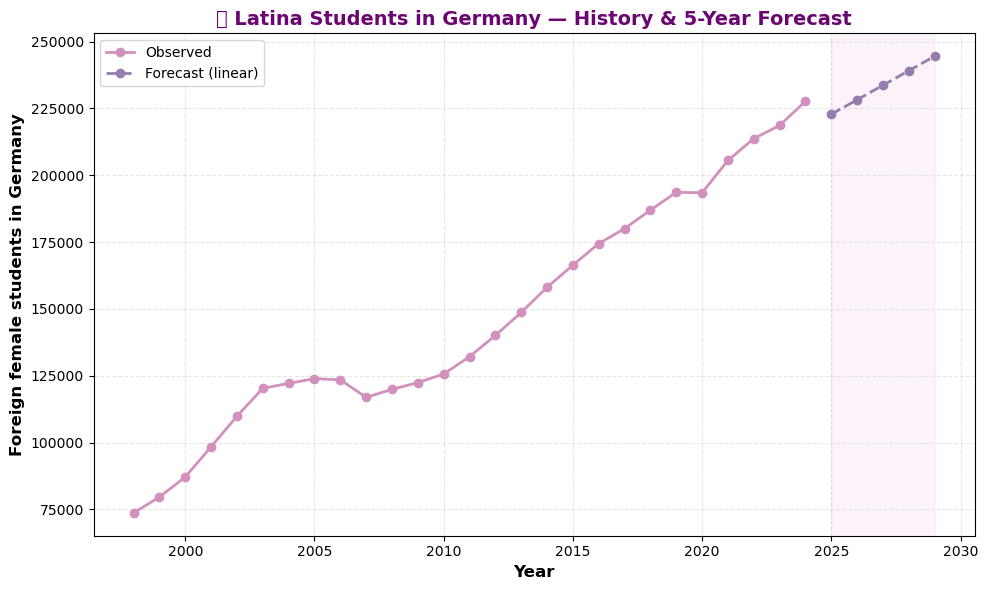

Forecast (next 5 years):
2025: 222,820
2026: 228,253
2027: 233,685
2028: 239,118
2029: 244,550


In [565]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot observed (solid line, pink)
plt.plot(years, vals, marker="o", color="#d291bc", label="Observed", linewidth=2)

# Plot forecast (dashed line, purple)
plt.plot(future_years, y_forecast, marker="o", linestyle="--", color="#957dad", label="Forecast (linear)", linewidth=2)

# Highlight forecast area with a light background
plt.axvspan(future_years[0], future_years[-1], color="#f8e1f4", alpha=0.4)

# Labels & title
plt.xlabel("Year", fontsize=12, weight="bold")
plt.ylabel("Foreign female students in Germany", fontsize=12, weight="bold")
plt.title("📈 Latina Students in Germany — History & 5-Year Forecast", fontsize=14, weight="bold", color="#6a0572")

# Add grid & style
plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# Forecast table
print("Forecast (next 5 years):")
for yr, yf in zip(future_years, y_forecast):
    print(f"{int(yr)}: {int(round(yf)):,}")


## Forecasts suggest steady growth in Latina student presence in Germany, continuing the upward trajectory of the past decade. If scholarships and policies remain stable, we expect 30–40% more students within five years.